# Chapter 16: Real life full project

### 16.1. Preparation of the data
> ###### 16.1.1. Importation of the data
> ###### 16.1.2. Features engineering
> ###### 16.1.3. Tain, test and validation sets	

### 16.2. Modelling the strategy
> ###### 16.2.1. Find the best assets
> ###### 16.2.2. Combine the algorithms	
> ###### 16.2.3. Apply portfolio management technics

### 16.3. Find optimal take profit, stop loss and leverage
> ###### 16.3.1. Optimal take profit	
> ###### 16.3.2. Optimal stop loss
> ###### 16.3.3. Optimal leverage


In [1]:
import numpy as np
import pandas as pd
import MetaTrader5 as mt5
import time
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
mt5.initialize()
import ta

### 16.1.1. Importation of the data

In [2]:
# INITIALIZE THE DEVICE
mt5.initialize()

# Create empty lists
symbols = []
sectors = []
descriptions = []

# Get the information for all symbol
symbols_information = mt5.symbols_get()

# Tuple to list
symbols_information_list = list(symbols_information)

# Extract the name of the symbol
for element in symbols_information_list:
    symbols.append(list(element)[-3])
    sectors.append(list(element)[-1].split("\\")[0])
    descriptions.append(list(element)[-7])
    
# Create a dataframe
informations = pd.DataFrame([symbols, sectors, descriptions], index=["Symbol", "Sector", "Description"]).transpose()


# Create empty list
spread = []

# Computze the spread
for symbol in informations["Symbol"]:
    try:
        ask =  mt5.symbol_info_tick(symbol).ask
        bid =  mt5.symbol_info_tick(symbol).bid
        spread.append((ask - bid) / bid )
        
    except:
        spread.append(None)

# Take the assets with the spread < 0.07%
informations["Spread"] = spread
lowest_spread_asset = informations.dropna().loc[informations["Spread"]<0.0035]

In [3]:
def get_data(symbol, n, timeframe=mt5.TIMEFRAME_D1):
    """ Function which returns the data of the symbol"""

    # Initialize MetaTrader device
    mt5.initialize()
    
    # Put the data in a dataframe
    utc_from = datetime.now()+timedelta(hours=2)
    rates = mt5.copy_rates_from(symbol, timeframe, utc_from,n) 
    rates_frame = pd.DataFrame(rates)
    
    # Convert time in seconds into the datetime format 
    rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
    rates_frame['time'] =  pd.to_datetime(rates_frame['time'], format='%Y-%m-%d')
    rates_frame = rates_frame.set_index('time')
    
    return rates_frame

### 16.1.2. Features engineering 

In [4]:
def features_engineering(df):
    """ This function which creates all the necessary sets for the algorithms"""

    # Allows the variables to be call outside the function
    global X_train
    global X_test
    global y_train_reg
    global y_train_cla 
    global X_train_scaled 
    global X_test_scaled
    global split_train_test
    global split_test_valid
    global X_valid
    global X_valid_scaled
    global X_train_pca
    global X_test_pca
    global X_val_pca


    # Create ours own metrics to compute the strategy returns
    df["returns"] = ((df["close"] - df["close"].shift(1)) / df["close"])
    df["sLow"] = ((df["low"] - df["close"].shift(1)) / df["close"].shift(1))
    df["sHigh"] = ((df["high"] - df["close"].shift(1)) / df["close"].shift(1))

    # Features engineering
    df["returns t-1"] = df[["returns"]].shift(1)

    # Mean of returns
    df["mean returns 15"] = df[["returns"]].rolling(15).mean().shift(1)
    df["mean returns 60"] = df[["returns"]].rolling(60).mean().shift(1)

    # Volatility of returns
    df["volatility returns 15"] = df[["returns"]].rolling(15).std().shift(1)
    df["volatility returns 60"] = df[["returns"]].rolling(60).std().shift(1)

    # Drop missing values
    df = df.dropna()
    
    # Percentage train set
    split = int(0.80*len(df))
   

   
    list_x = ["returns t-1", "mean returns 15", "mean returns 60",
                  "volatility returns 15",
                  "volatility returns 60"]


    split_train_test = int(0.70*len(df))
    split_test_valid = int(0.90*len(df))

    # Train set creation
    X_train = df[list_x].iloc[:split_train_test]

    y_train_reg = df[["returns"]].iloc[:split_train_test]

    y_train_cla = np.round(df[["returns"]].iloc[:split_train_test]+0.5)


    # Test set creation
    X_test = df[list_x].iloc[split_train_test:split_test_valid]
    
    # Test set creation
    X_val = df[list_x].iloc[split_test_valid:]


    # NORMALIZATION 
    # Import the class
    from sklearn.preprocessing import StandardScaler

    # Initialize the class
    sc = StandardScaler()

    # Standardize the data
    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.transform(X_test)
    X_val_scaled = sc.transform(X_val)
    
    
    
    
    
    # PCA
    # Import the class
    from sklearn.decomposition import PCA
    
    # Initiliaze the class
    pca = PCA(n_components=3)
    
    # Apply the PCA
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    

### 16.2.1. Find the best assets

In [5]:
def predictor(df, model, reg=True, spread = 0.035):
    model.fit(X_train_pca, y_train_cla)


    df = df.dropna()
    # Create predictions for the whole dataset
    df["prediction"] = model.predict(np.concatenate((X_train_pca,X_test_pca, X_val_pca),
                                        axis=0))

    if reg==False:
        df["prediction"] = np.where(df["prediction"]==0, -1, 1)

    df["prediction"] = df.prediction
    df=df.dropna()
    # Compute the strategy
    df["strategy"] = df["prediction"]* df["returns"]

    returns = df["strategy"].iloc[split_train_test:split_test_valid]

    return np.sqrt(252) * (returns.mean()-(spread/100))/ returns.std()

In [6]:
# Import the class
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm
# Models
tree = DecisionTreeClassifier(max_depth=6)
svr = SVC(C=1.5)
lin = LogisticRegression()


# Initialization
symbols = lowest_spread_asset["Symbol"]
lists = []
lenght = []
mt5.initialize()
for symbol in tqdm(symbols):
    
    try:
        df = get_data(symbol, 3500).dropna()

        df["returns"] = (df["close"] - df["close"].shift(1)) / df["close"].shift(1)


        features_engineering(df)


        """ Decision tree rgressor"""
        sharpe_tree = predictor(df, tree, reg=True)    
        lists.append([symbol, "Tree", sharpe_tree, len(df)])

        """ SVR """
        sharpe_svr = predictor(df, svr, reg=False)    
        lists.append([symbol, "SVR", sharpe_svr, len(df)])

        """ Linear Regression"""
        sharpe_linreg = predictor(df, lin, reg=False)    
        lists.append([symbol, "LinReg", sharpe_linreg, len(df)])
    except:
        print("Issue during the importation of the data")



 96%|█████████▋| 54/56 [01:20<00:01,  1.14it/s]

Issue during the importation of the data
Issue during the importation of the data


 98%|█████████▊| 55/56 [01:20<00:00,  1.41it/s]

Issue during the importation of the data


100%|██████████| 56/56 [01:20<00:00,  1.44s/it]

Issue during the importation of the data


In [49]:
results = pd.DataFrame(lists, columns=["Symbol", "Model", "Sharpe", "Lenght"])
results.sort_values(by="Sharpe", ascending=False).loc[results["Lenght"]>600].head(35)

,Symbol,Model,Sharpe,Lenght
85,Bitcoin,SVR,2.946183,1127
86,Bitcoin,LinReg,2.364135,1127
87,JPN225,Tree,1.566649,1046
84,Bitcoin,Tree,1.525741,1127
91,NAS100,SVR,1.203514,1044
93,US2000,Tree,1.102277,1044
59,USDRUB,LinReg,1.068304,1720
82,XPTUSD,SVR,0.766540,1045
92,NAS100,LinReg,0.745942,1044
90,NAS100,Tree,0.630387,1044


### 16.2.2. Combine the algorithms

In [27]:
["US2000", "Bitcoin", "AUDUSD", "NAS100", "US500"]

['US2000', 'Bitcoin', 'AUDUSD', 'NAS100', 'US500']

In [57]:
def voting(df, reg=True):    
    """ Create a strategy using a voting method"""
    # Import the class
   
    
    # Import the models
    if reg:
        tree = DecisionTreeRegressor(max_depth=6)
        svr = SVR(epsilon=1.5)
        lin = LinearRegression()
        vot = VotingRegressor(estimators=[
            ('lr', lin), ("tree", tree), ("svr", svr)])
    else:
        tree = DecisionTreeClassifier(max_depth=6)
        svr = SVC()
        lin = LogisticRegression()

        vot = VotingClassifier(estimators=[
            ('lr', lin), ("tree", tree), ("svr", svr)])

    # Train the model
    if reg==False:
        vot.fit(X_train_pca, y_train_cla)
    else:
        vot.fit(X_train_pca, y_train_reg)

    # Remove missing values 
    df = df.dropna()
    
    # Create predictions for the whole dataset
    df["prediction"] = vot.predict(np.concatenate((X_train_pca,
                                                   X_test_pca,
                                                   X_val_pca),
                                        axis=0))
    
    # Remove missing values 
    df = df.dropna()
    
    if reg==False:
        df["prediction"] = np.where(df["prediction"]==0, -1, 1)

    # Compute the strategy
    df["strategy"] = np.sign(df["prediction"]) * df["returns"]
    df["low_strategy"] = np.where(df["prediction"]>0, df["sLow"], -df["sHigh"])
    df["high_strategy"] = np.where(df["prediction"]>0, df["sHigh"], -df["sLow"])


    return vot, df["strategy"], df["low_strategy"], df["high_strategy"]

In [58]:
mt5.initialize()

# Import the class
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.ensemble import VotingRegressor, VotingClassifier
import pickle
from joblib import dump, load

# Initialization
lists = []
res = pd.DataFrame()
low_assets = pd.DataFrame()
high_assets = pd.DataFrame()

for symbol in ["US2000", "Bitcoin", "JPN225", "XPTUSD", "NAS100"]:
    print(symbol)
    
    
    # Import the data
    df = get_data(symbol, 3500).dropna()
    
    # Create ours own metrics to compute the strategy returns
    df["returns"] = ((df["close"] - df["close"].shift(1)) / df["close"])
    df["sLow"] = ((df["low"] - df["close"].shift(1)) / df["close"].shift(1))
    df["sHigh"] = ((df["high"] - df["close"].shift(1)) / df["close"].shift(1))
    # Remove missing values
    df = df.dropna()
    
    # Create the sets
    features_engineering(df)

    # Compute the strategy
    vot, res[symbol],low_assets[symbol],high_assets[symbol] = voting(df, reg=False)

    # Save the model
    s = pickle.dumps(vot)
    alg = pickle.loads(s)

    dump(alg ,f"Models/{symbol}_voting.joblib")

US2000
Bitcoin
JPN225
XPTUSD
NAS100


<AxesSubplot:xlabel='time'>

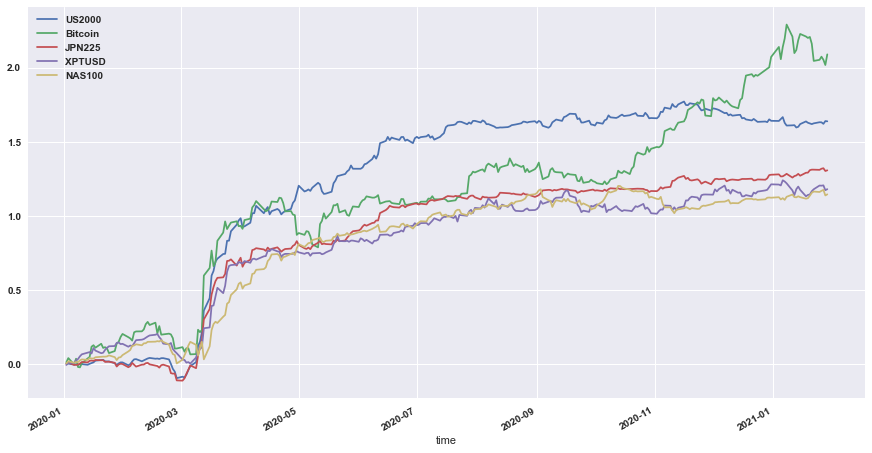

In [59]:
# Display cumulative returns of the strategies on the test set
data = res.dropna().loc["2020-01":"2021-01"]
data.cumsum().plot(figsize=(15,8))

### 16.2.3. Apply portfolio management technics

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.25406110980306784
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7
[0.317 0.501 0.112 0.    0.071]
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.144 	 Alpha: 27.36 %	     Sharpe: 0.603 	 Sortino: 0.954
  -----------------------------------------------------------------------------
    VaR: 66.55 %	 cVaR: 79.59 % 	     VaR/cVaR: 1.196 	 drawdown: 20.91 %
  -----------------------------------------------------------------------------


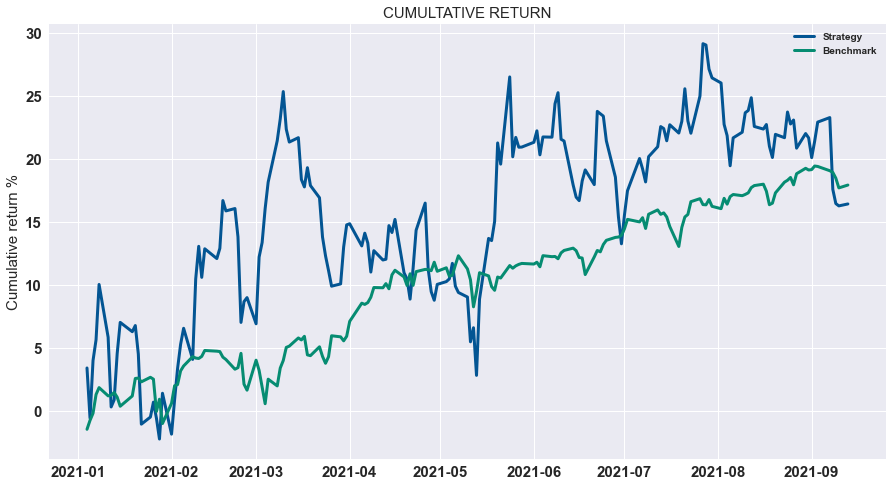

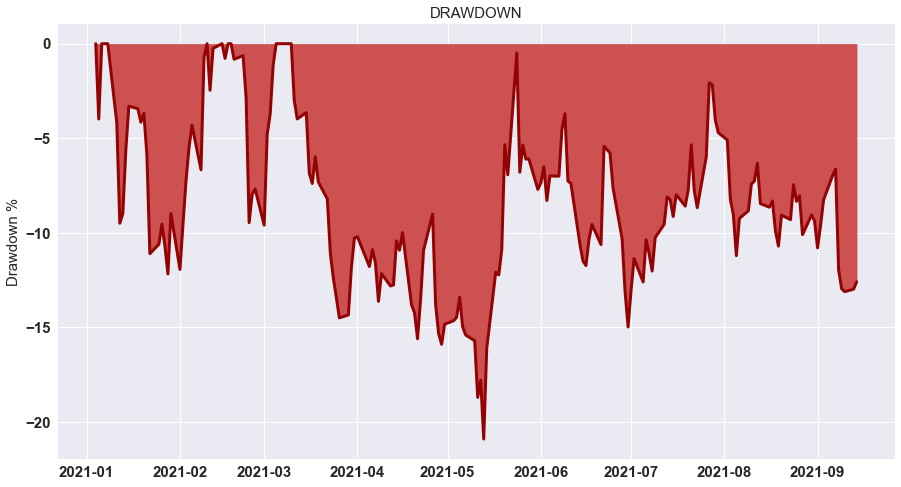

In [86]:
from quantreo.portfolio import *
data = res.dropna().loc["2020-01":"2021-01"]
val = res.dropna().loc["2021-01":]

X = optimization_portfolio(MV_criterion, data)

print(np.round(X,3))

spread = 0.00035
low_portfolio = np.multiply(low_assets,np.transpose(X)).sum(axis=1)
high_portfolio = np.multiply(high_assets,np.transpose(X)).sum(axis=1)


# Compute the cumulative return of the portfolio (CM)
portfolio_return_test = np.multiply(data,np.transpose(X)).sum(axis=1)
portfolio_return_MV = np.multiply(val,np.transpose(X)).sum(axis=1)

from Backtest import *
import yfinance as yf
backtest_dynamic_portfolio(portfolio_return_MV)

### 14.3.1. Optimal take profit

In [71]:
def find_best_tp(tp):
    tp = tp/100
    
    # Create the portfolio
    pf = pd.concat((low_portfolio, portfolio_return_test,high_portfolio), axis=1).dropna()-spread
    pf.columns = ["low", "Return", "high"]

    # Apply the tp
    pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
    pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)
    down = pf["Return"].values
    down = down[down<0]
    
    # Return sharpe raatio
    return np.sqrt(252)*pf["Return"].mean()/down.std()

pd.DataFrame([find_best_tp(tp) for tp in np.linspace(0.5,10,30)],  index=np.linspace(0.5,10,30), columns=["Sharpe"])

,Sharpe
0.500000,5.104012
0.827586,5.454733
1.155172,5.896520
1.482759,6.471672
1.810345,6.460114
2.137931,7.026310
2.465517,6.685002
2.793103,5.754480
3.120690,5.696021
3.448276,6.066583


[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.103 	 Alpha: 49.44 %	     Sharpe: 1.573 	 Sortino: 2.139
  -----------------------------------------------------------------------------
    VaR: 26.09 %	 cVaR: 38.18 % 	     VaR/cVaR: 1.463 	 drawdown: 10.1 %
  -----------------------------------------------------------------------------


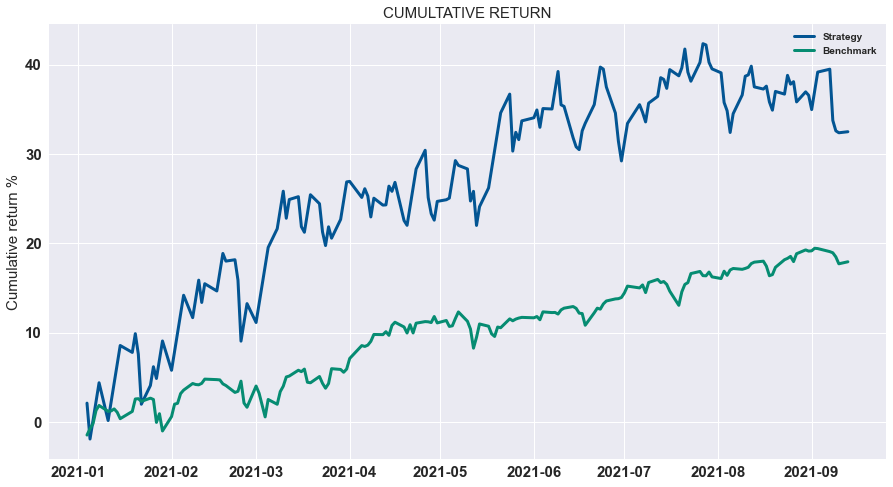

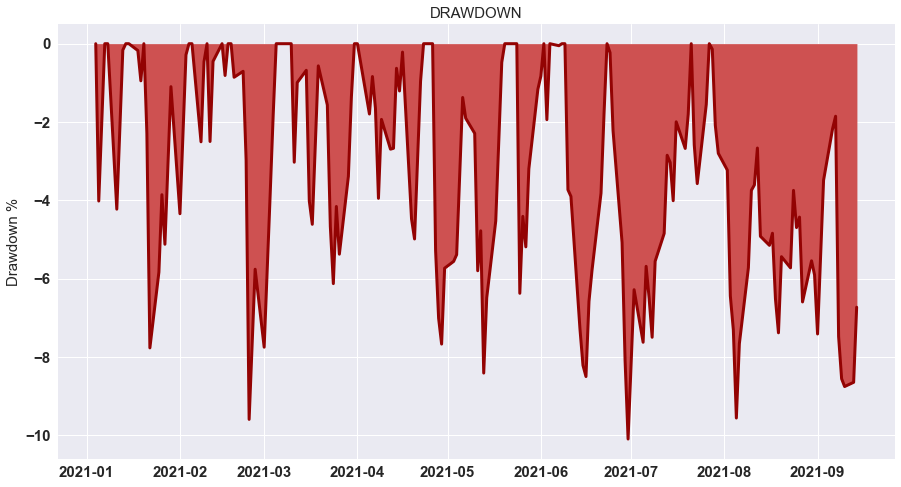

In [73]:
tp = 2.1/100
pf = pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna()-spread
pf.columns = ["low", "Return", "high"]

pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)

backtest_dynamic_portfolio(pf["Return"])

### 16.3.2. Optimal stop loss

In [61]:
def find_best_sl(sl):
    sl = sl/100
    
    # Create the portfolio
    pf = pd.concat((low_portfolio, portfolio_return_test,high_portfolio), axis=1).dropna()-spread
    pf.columns = ["low", "Return", "high"]

    # Apply the tp
    pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
    pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)
    
    # Return sharpe raatio
    return np.sqrt(252)*pf["Return"].mean()/pf["Return"].std()

pd.DataFrame([find_best_sl(sl) for sl in np.linspace(1,10,30)],  index=np.linspace(1,10,30), columns=["Sharpe"])

,Sharpe
1.000000,-1.375686
1.310345,-0.930839
1.620690,-0.465171
1.931034,-0.290011
2.241379,0.615358
2.551724,1.055019
2.862069,1.367951
3.172414,1.349833
3.482759,1.653049
3.793103,2.049993


[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.141 	 Alpha: 12.1 %	     Sharpe: 0.211 	 Sortino: 0.308
  -----------------------------------------------------------------------------
    VaR: 85.45 %	 cVaR: 99.35 % 	     VaR/cVaR: 1.163 	 drawdown: 22.16 %
  -----------------------------------------------------------------------------


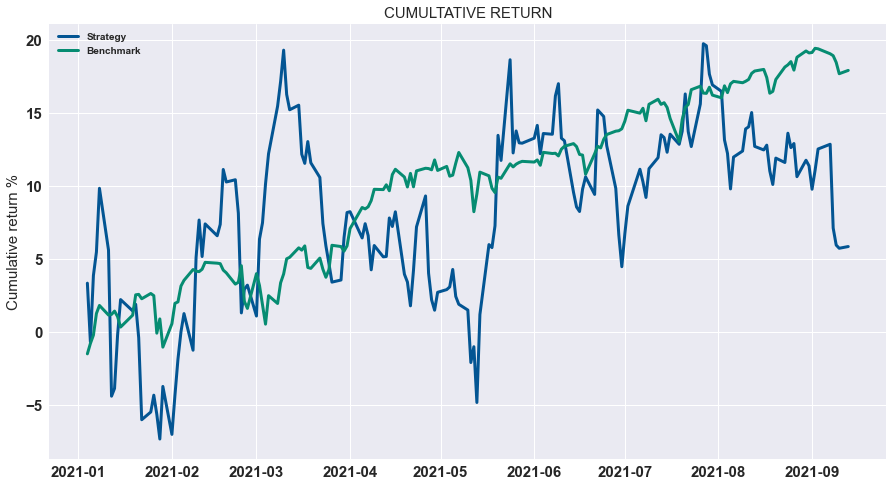

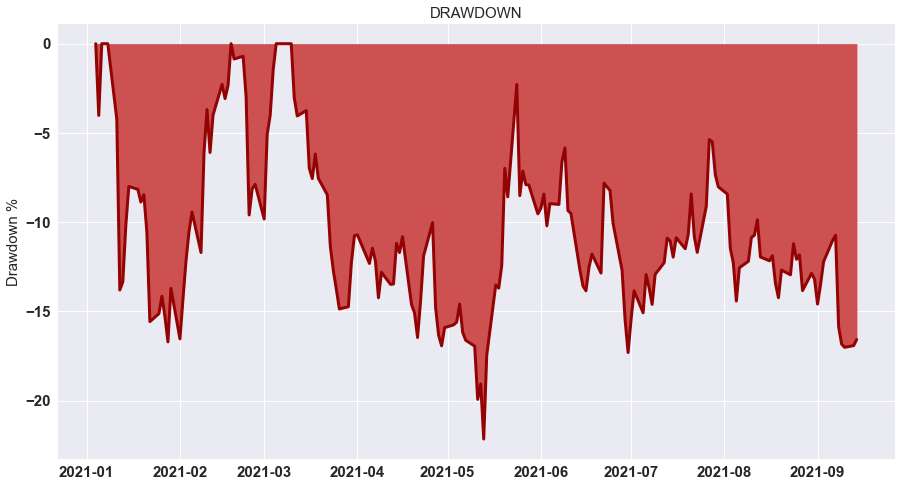

In [82]:
sl = 10/100
pf = pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna()-spread

pf.columns = ["low", "Return", "high"]
pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)


backtest_dynamic_portfolio(pf["Return"])

### 14.3.3. Optimal leverage

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.174 	 Alpha: 93.37 %	     Sharpe: 2.178 	 Sortino: 2.529
  -----------------------------------------------------------------------------
    VaR: 5.95 %	 cVaR: 20.88 % 	     VaR/cVaR: 3.508 	 drawdown: 13.32 %
  -----------------------------------------------------------------------------


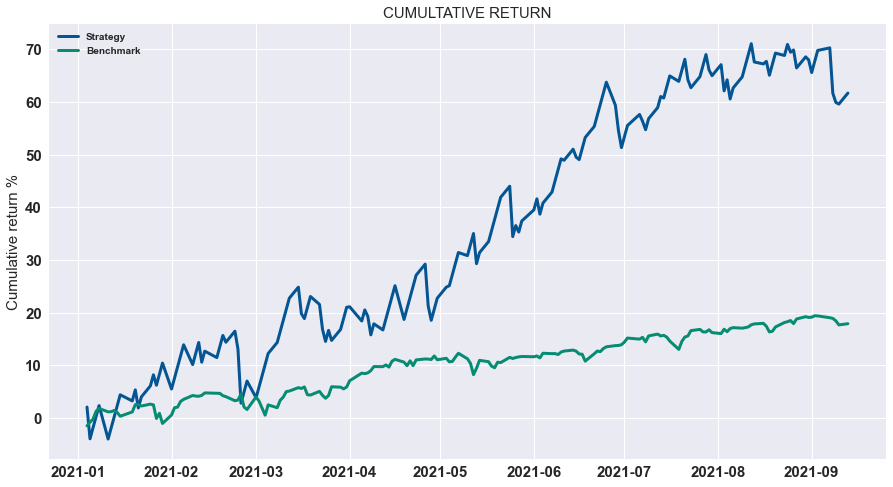

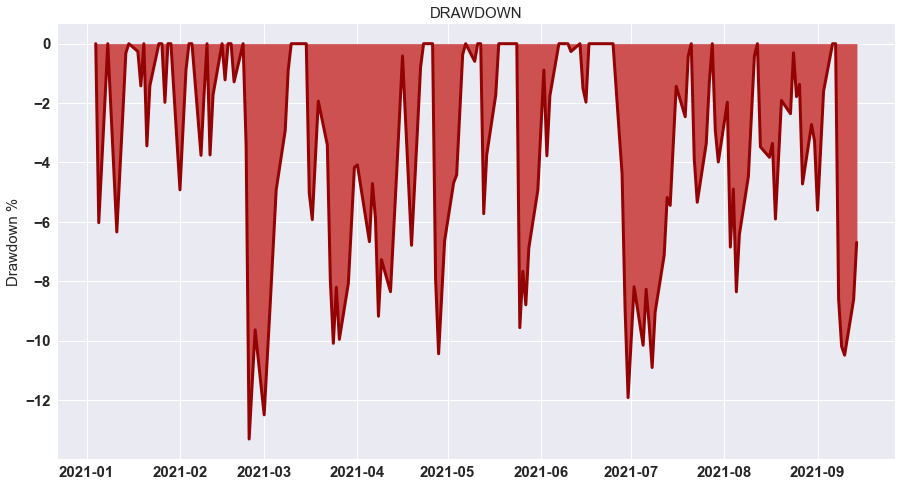

In [85]:
leverage = 1.5
tp = 2.1/100
sl = 7.3
pf = (pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna()-spread)*leverage
pf.columns = ["low", "Return", "high"]

pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)

# Plot the CM
backtest_dynamic_portfolio(pf["Return"])

Why has the performance does not grown since 06-2021? There are some explanations. The period's volatility is less than the other, and the strategy does not work on it, or the weight of the algorithm needs to be adjusted because the market situation has evolved.

Congratulations!

You have read the whole book. It is normal if you do not have to understand all the notions. To a better understanding, I advise you to use your news skills in your projects.
